## I. Import Library + Dataset

In [118]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score, make_scorer, recall_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score
)

In [119]:
df_original = pd.read_csv('students_mental_health_survey.csv')

In [120]:
df_original

,Age,Course,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
0,25,Others,Male,3.56,3,3,2,Good,Moderate,Good,Moderate,Married,Never,Never,No,No,2,Moderate,17,On-Campus
1,24,Engineering,Female,2.44,0,3,0,Average,Low,Average,Low,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus
2,19,Business,Female,3.74,4,0,3,Good,Low,Average,Moderate,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus
3,19,Computer Science,Male,3.65,2,1,0,Average,Low,Average,Moderate,Single,NaN,Never,No,No,4,Moderate,20,Off-Campus
4,18,Business,Male,3.40,3,3,4,Good,Low,Average,High,Married,Never,Never,No,Yes,0,High,23,On-Campus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7017,20,Law,Female,3.69,3,1,5,Good,Low,Poor,High,Single,Never,Frequently,Yes,No,1,High,26,Off-Campus
7018,24,Medical,Female,3.73,3,4,1,Good,Moderate,Average,High,Single,Never,Occasionally,No,No,3,Low,15,Off-Campus
7019,26,Others,Male,3.65,4,5,1,Good,High,Poor,Moderate,Married,Never,Occasionally,No,Yes,4,Moderate,17,Off-Campus
7020,24,Medical,Male,3.65,4,3,4,Average,High,Poor,Moderate,Single,Never,Never,No,Yes,4,Moderate,18,Off-Campus


## II. Data processing (Initial approach)

In [121]:
df_original['Stress_Level'].value_counts()

Stress_Level
3    1405
2    1279
1    1233
0    1098
5    1015
4     992
Name: count, dtype: int64

In [122]:
df_original.dtypes

Age                              int64
Course                          object
Gender                          object
CGPA                           float64
Stress_Level                     int64
Depression_Score                 int64
Anxiety_Score                    int64
Sleep_Quality                   object
Physical_Activity               object
Diet_Quality                    object
Social_Support                  object
Relationship_Status             object
Substance_Use                   object
Counseling_Service_Use          object
Family_History                  object
Chronic_Illness                 object
Financial_Stress                 int64
Extracurricular_Involvement     object
Semester_Credit_Load             int64
Residence_Type                  object
dtype: object

In [123]:
#Count null values from each column
df_original.isna().sum()

Age                             0
Course                          0
Gender                          0
CGPA                           12
Stress_Level                    0
Depression_Score                0
Anxiety_Score                   0
Sleep_Quality                   0
Physical_Activity               0
Diet_Quality                    0
Social_Support                  0
Relationship_Status             0
Substance_Use                  15
Counseling_Service_Use          0
Family_History                  0
Chronic_Illness                 0
Financial_Stress                0
Extracurricular_Involvement     0
Semester_Credit_Load            0
Residence_Type                  0
dtype: int64

### Train - test split
- We split the data first, because if impute or do some data transformation, info in test set (like mean, categories frequency, outlier range,...) might go in to preprocessing parameter
- This will make test performance overly optimistic.

In [124]:
df = df_original.copy()

In [125]:
#Do some mapping
df['Family_History'] = df['Family_History'].map({'No': 0, 'Yes': 1})
df['Chronic_Illness'] = df['Chronic_Illness'].map({'No': 0, 'Yes': 1})
df['Residence_Type'] = df['Residence_Type'].map({'On-Campus': 1, 'Off-Campus': 0, 'With Family': 2})

In [126]:
TARGET = 'Stress_Level'
y = df[TARGET]
X = df.drop(columns=[TARGET])

In [127]:
all_cols = list(X.columns)

#Identify categorical vs numerical columns
num_cols = ['Age','CGPA','Semester_Credit_Load', 'Family_History','Chronic_Illness']
cat_cols = [c for c in all_cols if c not in num_cols]
all_ordinal_cols = ['Depression_Score', 'Anxiety_Score', 'Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support', 'Substance_Use', 'Counseling_Service_Use', 'Financial_Stress', 'Extracurricular_Involvement']

In [128]:
ordinal_cols = [c for c in all_ordinal_cols if c in X.columns]
nominal_cols = [c for c in cat_cols if c not in ordinal_cols]

#### Custom Ranking: Use to pass to Ordinal Encoder: <br>
##### 0-> 5 
- Stress_level, Depression_Score, Anxiety_Score, Financial_stress
##### Poor Average Good
- Sleep Quality, Diet_Quality
##### Low Moderate High
- Physical_Activity, Social_Support, Extracurricular_Involvement
##### Never, Occasionally, Frequently
- Substance_Use, Counseling_Service_Use, 

In [129]:
categories_mapping = {
    'Depression_Score':      list(range(6)),  # 0,1,2,3,4,5
    'Anxiety_Score':         list(range(6)),
    'Sleep_Quality':         ['Poor','Average','Good'],
    'Physical_Activity':     ['Low','Moderate','High'],
    'Diet_Quality':          ['Poor','Average','Good'],
    'Social_Support':        ['Low','Moderate','High'],
    'Substance_Use':         ['Never','Occasionally','Frequently'],
    'Counseling_Service_Use':['Never','Occasionally','Frequently'],
    'Financial_Stress':      list(range(6)),
    'Extracurricular_Involvement':['Low','Moderate','High'],
}

In [130]:
categories = [categories_mapping[col] for col in ordinal_cols]

In [131]:
# Treat Missing data & Apply Encoding
preprocessor = ColumnTransformer([
    ("nums", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale",  StandardScaler())
    ]), num_cols),

    ("ords", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ord",    OrdinalEncoder(categories=categories, dtype=int))
    ]), ordinal_cols),

    ("noms", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe",    OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), nominal_cols),
])

In [132]:
# 70% train, 15% val, 15% test with stratification on y
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [133]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((4915, 19), (1053, 19), (1054, 19), (4915,), (1053,), (1054,))

In [134]:
def show_distribution(name, y):
    counts = y.value_counts().sort_index()
    props  = y.value_counts(normalize=True).sort_index()
    df = pd.DataFrame({
        'count': counts,
        'pct':   props.round(3)
    })
    print(f"\n{name} set distribution:")
    print(df)

# Call for each split
show_distribution('Train', y_train)
show_distribution('Validation', y_val)
show_distribution('Test', y_test)


Train set distribution:
              count    pct
Stress_Level              
0               769  0.156
1               863  0.176
2               895  0.182
3               983  0.200
4               694  0.141
5               711  0.145

Validation set distribution:
              count    pct
Stress_Level              
0               164  0.156
1               185  0.176
2               192  0.182
3               211  0.200
4               149  0.142
5               152  0.144

Test set distribution:
              count    pct
Stress_Level              
0               165  0.157
1               185  0.176
2               192  0.182
3               211  0.200
4               149  0.141
5               152  0.144


### Apply Preprocessor & Encoding

In [135]:
X_train.dtypes

Age                              int64
Course                          object
Gender                          object
CGPA                           float64
Depression_Score                 int64
Anxiety_Score                    int64
Sleep_Quality                   object
Physical_Activity               object
Diet_Quality                    object
Social_Support                  object
Relationship_Status             object
Substance_Use                   object
Counseling_Service_Use          object
Family_History                   int64
Chronic_Illness                  int64
Financial_Stress                 int64
Extracurricular_Involvement     object
Semester_Credit_Load             int64
Residence_Type                   int64
dtype: object

In [136]:
preprocessor.fit(X_train)

X_train_prepared = preprocessor.transform(X_train)
X_val_prepared   = preprocessor.transform(X_val)
X_test_prepared  = preprocessor.transform(X_test)

## III. Model

### My Baseline model: Random Forest

In [137]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'   # or 'balanced'
)
rf.fit(X_train_prepared, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=42)

### Evaluate on the validation set

In [138]:
# Predict on validation
y_val_pred = rf.predict(X_val_prepared)
val_acc = accuracy_score(y_val, y_val_pred)

# Compute metrics
print(f"Validation Accuracy: {val_acc:.3f}\n")
print("Classification Report (Val):")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.181

Classification Report (Val):
              precision    recall  f1-score   support

           0       0.20      0.23      0.21       164
           1       0.15      0.18      0.17       185
           2       0.14      0.14      0.14       192
           3       0.16      0.18      0.17       211
           4       0.21      0.16      0.18       149
           5       0.26      0.21      0.23       152

    accuracy                           0.18      1053
   macro avg       0.19      0.18      0.18      1053
weighted avg       0.19      0.18      0.18      1053



### Hyperparameter Tuning

In [139]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(
        # n_estimators=100,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ))
])

param_distributions = {
    "rf__criterion":        ["gini", "entropy", "log_loss"],
    "rf__n_estimators":     randint(100, 1000),
    "rf__max_depth":        [None] + list(range(5, 31, 5)),
    "rf__min_samples_split":randint(2, 11),
    "rf__min_samples_leaf": randint(1, 5),
    "rf__max_features":     ["auto", "sqrt", "log2", 0.2, 0.5, None],
    "rf__class_weight":     [None, "balanced", "balanced_subsample"]
}

# Here I want to have class 5 weighted more than others
def recall_with_extra_weight(y_true, y_pred):
    # get per-class recalls in order of label
    per_class = recall_score(y_true, y_pred, average=None,
                             labels=np.unique(y_true))
    # build weights: 1 for every class except e.g. 5 → 5× weight
    weights = np.ones_like(per_class, dtype=float)
    # find the index of class=5 in your labels array
    labels = np.unique(y_true)
    idx5 = np.where(labels == 5)[0][0]
    weights[idx5] = 5.0

    # weighted average
    return np.average(per_class, weights=weights)

# wrap as a scorer
weighted_recall_scorer = make_scorer(
    recall_with_extra_weight,
    greater_is_better=True
)

# set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring=weighted_recall_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
# 4) Run the search on the raw X_train / y_train
random_search.fit(X_train, y_train)

# 5) Inspect best params & CV score
print("Best CV score: {:.4f}".format(random_search.best_score_))
print("Best hyperparameters:\n", random_search.best_params_)

# 6) Evaluate on validation (or test) set
y_val_pred = random_search.predict(X_val)
print("\nValidation Accuracy: {:.4f}".format(accuracy_score(y_val, y_val_pred)))
print(classification_report(y_val, y_val_pred))

y_test_pred = random_search.predict(X_test)
print("\nTest Accuracy:       {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print(classification_report(y_test, y_test_pred))

print(f"Val accuracy:  {random_search.best_estimator_.score(X_val, y_val):.4f}")
print(f"Test accuracy: {random_search.best_estimator_.score(X_test, y_test):.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END rf__class_weight=balanced, rf__criterion=log_loss, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=472; total time=   2.1s
[CV] END rf__class_weight=balanced, rf__criterion=log_loss, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=472; total time=   2.1s
[CV] END rf__class_weight=balanced, rf__criterion=log_loss, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=472; total time=   2.1s
[CV] END rf__class_weight=balanced, rf__criterion=log_loss, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=472; total time=   2.2s
[CV] END rf__class_weight=balanced, rf__criterion=log_loss, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=472; to

Exception ignored in: <function ResourceTracker.__del__ at 0x105918680>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/Users/markjulie/mark_repos/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rf__class_weight=None, rf__criterion=log_loss, rf__max_depth=None, rf__max_features=0.2, rf__min_samples_leaf=2, rf__min_samples_split=9, rf__n_estimators=951; total time=   4.4s
[CV] END rf__class_weight=None, rf__criterion=gini, rf__max_depth=15, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=497; total time=   0.0s
[CV] END rf__class_weight=None, rf__criterion=log_loss, rf__max_depth=None, rf__max_features=0.2, rf__min_samples_leaf=2, rf__min_samples_split=9, rf__n_estimators=951; total time=   4.4s
[CV] END rf__class_weight=None, rf__criterion=gini, rf__max_depth=15, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=497; total time=   0.0s
[CV] END rf__class_weight=None, rf__criterion=gini, rf__max_depth=15, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=497; total time=   0.1s
[CV] END rf__class_weight=balanced, rf__criterion=entropy, rf__max_depth=5,

Exception ignored in: <function ResourceTracker.__del__ at 0x104838680>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END rf__class_weight=balanced_subsample, rf__criterion=log_loss, rf__max_depth=25, rf__max_features=None, rf__min_samples_leaf=2, rf__min_samples_split=7, rf__n_estimators=329; total time=   3.7s
[CV] END rf__class_weight=balanced_subsample, rf__criterion=log_loss, rf__max_depth=25, rf__max_features=None, rf__min_samples_leaf=2, rf__min_samples_split=7, rf__n_estimators=329; total time=   3.8s
[CV] END rf__class_weight=balanced_subsample, rf__criterion=log_loss, rf__max_depth=25, rf__max_features=None, rf__min_samples_leaf=2, rf__min_samples_split=7, rf__n_estimators=329; total time=   3.8s
[CV] END rf__class_weight=balanced_subsample, rf__criterion=log_loss, rf__max_depth=25, rf__max_features=None, rf__min_samples_leaf=2, rf__min_samples_split=7, rf__n_estimators=329; total time=   3.8s
[CV] END rf__class_weight=balanced_subsample, rf__criterion=log_loss, rf__max_depth=25, rf__max_features=None, rf__min_samples_leaf=2, rf__min_samples_split=7, rf__n_estimators=329; total time=   

/Users/markjulie/mark_repos/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/markjulie/mark_repos/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/markjulie/mark_repos/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/markjulie/mark_repos/.venv/lib/python3.13/s

Best CV score: 0.2130
Best hyperparameters:
 {'rf__class_weight': 'balanced_subsample', 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 8, 'rf__n_estimators': 120}

Validation Accuracy: 0.1871
              precision    recall  f1-score   support

           0       0.21      0.41      0.28       164
           1       0.19      0.24      0.21       185
           2       0.07      0.04      0.05       192
           3       0.12      0.04      0.06       211
           4       0.21      0.22      0.22       149
           5       0.23      0.23      0.23       152

    accuracy                           0.19      1053
   macro avg       0.17      0.20      0.18      1053
weighted avg       0.17      0.19      0.17      1053


Test Accuracy:       0.2154
              precision    recall  f1-score   support

           0       0.21      0.44      0.28       165
           1       0.21      0.25      0.23       1

In [140]:
# Get the best model
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'rf__class_weight': 'balanced_subsample', 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 8, 'rf__n_estimators': 120}


### Refit on Train + Validation set

In [141]:
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

### Final Evaluation on the test set

In [142]:
rf_kwargs = {k.split("__")[1]: v for k, v in best_params.items() if k.startswith("rf__")}

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),  # same ColumnTransformer you used before
    ("rf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **rf_kwargs
    ))
])

In [143]:
#Fit on the combined training+validation data
final_pipeline.fit(X_train_val, y_train_val)

# Evaluate on the held‐out test set
y_test_pred = final_pipeline.predict(X_test)

In [144]:
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}\n")
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
confusion_matrix(y_test, y_test_pred)

Test Accuracy: 0.2097

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.21      0.44      0.28       165
           1       0.22      0.28      0.25       185
           2       0.14      0.08      0.10       192
           3       0.25      0.05      0.09       211
           4       0.23      0.31      0.27       149
           5       0.19      0.16      0.18       152

    accuracy                           0.21      1054
   macro avg       0.21      0.22      0.19      1054
weighted avg       0.21      0.21      0.19      1054

Confusion Matrix (Test):


array([[73, 36, 26, 13, 11,  6],
       [75, 51, 18,  4, 22, 15],
       [68, 53, 15,  7, 25, 24],
       [62, 39, 24, 11, 48, 27],
       [31, 28,  9,  3, 46, 32],
       [41, 22, 12,  6, 46, 25]])

### ROC-AUC & PR Curve on Initial Approach

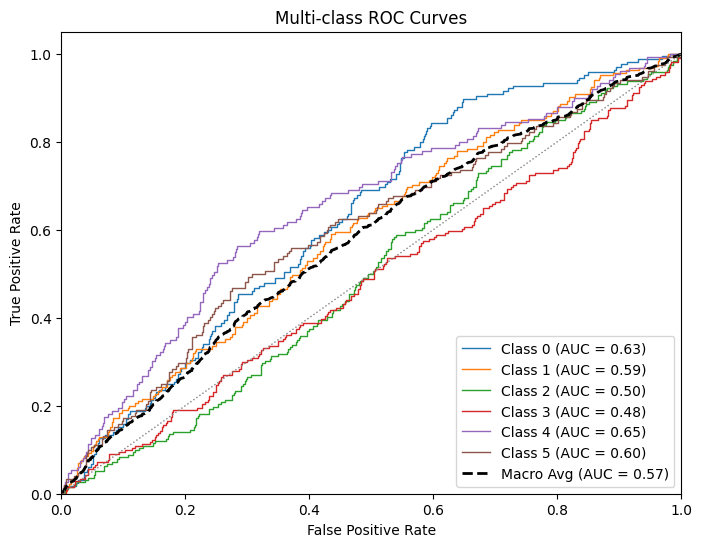

In [145]:
# 1) Binarize the true labels for all 6 classes
classes = [0, 1, 2, 3, 4, 5]
y_test_bin = label_binarize(y_test, classes=classes)

# 2) Get the predicted probabilities from your final pipeline
# (must be the pipeline with predict_proba)
y_score = final_pipeline.predict_proba(X_test)

# 3) Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4) Compute macro‐average ROC AUC
# flatten all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))
# interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in classes:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5) Plot
plt.figure(figsize=(8, 6))
# per‐class curves
for i, cls in enumerate(classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=1,
        label=f"Class {cls} (AUC = {roc_auc[i]:.2f})"
    )
# macro curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    color="black",
    lw=2,
    linestyle="--",
    label=f"Macro Avg (AUC = {roc_auc['macro']:.2f})"
)
# chance line
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle=":")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi‐class ROC Curves")
plt.legend(loc="lower right")
plt.show()

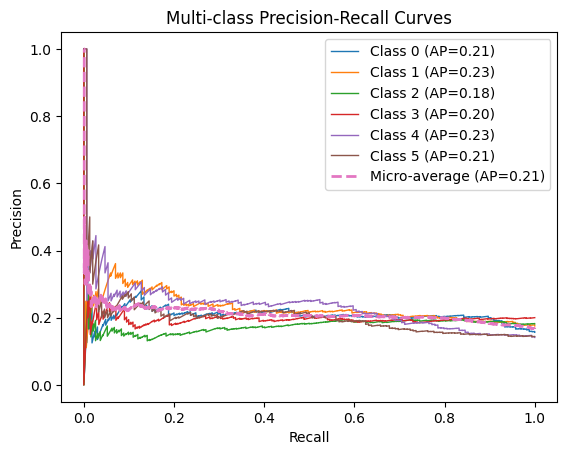

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.21      0.44      0.28       165
           1       0.22      0.28      0.25       185
           2       0.14      0.08      0.10       192
           3       0.25      0.05      0.09       211
           4       0.23      0.31      0.27       149
           5       0.19      0.16      0.18       152

    accuracy                           0.21      1054
   macro avg       0.21      0.22      0.19      1054
weighted avg       0.21      0.21      0.19      1054



In [146]:
precision = {}
recall = {}
average_precision = {}
for i in classes:
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Compute micro-average PR
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")

# Plot curves
plt.figure()
for i in classes:
    plt.plot(recall[i], precision[i], lw=1, label=f"Class {i} (AP={average_precision[i]:.2f})")
plt.plot(recall["micro"], precision["micro"], linestyle='--', lw=2,
         label=f"Micro-average (AP={average_precision['micro']:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curves")
plt.legend(loc="upper right")
plt.show()

# 7) Print classification report
y_pred = final_pipeline.predict(X_test)
print("Classification Report (Test):")
print(classification_report(y_test, y_pred))

## IV. Rechecking the data - Improving the Model

### Feature Importance

In [147]:
# Feature Importance
best_pipe = random_search.best_estimator_
rf = best_pipe.named_steps['rf']
pre = best_pipe.named_steps['preprocessor']
num_features = num_cols

ord_features = ordinal_cols

ohe: OneHotEncoder = pre.named_transformers_['noms'] \
                         .named_steps['ohe']
ohe_features = ohe.get_feature_names_out(nominal_cols).tolist()

feature_names = num_features + ord_features + ohe_features

# sanity check
assert len(feature_names) == rf.feature_importances_.shape[0]

# 5) Build a pandas Series and sort
importances = pd.Series(rf.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)
print("Top 20 feature importances:\n", importances.head(20))

Top 20 feature importances:
 CGPA                                     0.144482
Semester_Credit_Load                     0.094751
Age                                      0.093738
Course_Medical                           0.083259
Financial_Stress                         0.064379
Anxiety_Score                            0.062670
Depression_Score                         0.060124
Social_Support                           0.034682
Physical_Activity                        0.034495
Sleep_Quality                            0.033046
Extracurricular_Involvement              0.032336
Diet_Quality                             0.031080
Counseling_Service_Use                   0.028457
Family_History                           0.018135
Substance_Use                            0.017758
Relationship_Status_Single               0.017340
Residence_Type_1                         0.017210
Residence_Type_0                         0.017174
Relationship_Status_In a Relationship    0.014823
Gender_Female        

### Using different dataset (from different encoding method)

In [148]:
df_clean = pd.read_csv('label_encoded_data.csv')

In [149]:
df_clean.columns

Index(['Age', 'Course', 'Gender', 'CGPA', 'Stress_Level', 'Depression_Score',
       'Anxiety_Score', 'Sleep_Quality', 'Physical_Activity', 'Diet_Quality',
       'Social_Support', 'Relationship_Status', 'Substance_Use',
       'Counseling_Service_Use', 'Family_History', 'Chronic_Illness',
       'Financial_Stress', 'Extracurricular_Involvement',
       'Semester_Credit_Load', 'Residence_Type', 'Age_Bucket', 'CGPA_Bucket',
       'Financial_Stress_Level', 'Semester_Credit_Load_Bucket',
       'Mental_Health_Score', 'Mental_Health_Bucket', 'Course_Label',
       'Gender_Label', 'Sleep_Quality_Label', 'Physical_Activity_Label',
       'Diet_Quality_Label', 'Social_Support_Label',
       'Relationship_Status_Label', 'Substance_Use_Label',
       'Counseling_Service_Use_Label', 'Family_History_Label',
       'Chronic_Illness_Label', 'Extracurricular_Involvement_Label',
       'Residence_Type_Label', 'CGPA_Bucket_Label', 'Age_Bucket_Label',
       'Financial_Stress_Label', 'Semester_Credit_

In [150]:
df_clean.drop(columns=['Age_Bucket_Label', 'Age_Bucket', 'Course', 'Gender', 'CGPA_Bucket_Label', 'CGPA_Bucket', 'Financial_Stress_Label', 'Financial_Stress_Level','Substance_Use', 'Semester_Credit_Load_Bucket', 'Semester_Credit_Load_Bucket_Label', 'Counseling_Service_Use','Family_History','Chronic_Illness', 'Diet_Quality','Mental_Health_Bucket_Label', 'Mental_Health_Score', 'Mental_Health_Bucket', 'Extracurricular_Involvement','Relationship_Status', 'Social_Support', 'Physical_Activity', 'Residence_Type_Label'], inplace=True)

In [151]:
df_clean.columns

Index(['Age', 'CGPA', 'Stress_Level', 'Depression_Score', 'Anxiety_Score',
       'Sleep_Quality', 'Financial_Stress', 'Semester_Credit_Load',
       'Residence_Type', 'Course_Label', 'Gender_Label', 'Sleep_Quality_Label',
       'Physical_Activity_Label', 'Diet_Quality_Label', 'Social_Support_Label',
       'Relationship_Status_Label', 'Substance_Use_Label',
       'Counseling_Service_Use_Label', 'Family_History_Label',
       'Chronic_Illness_Label', 'Extracurricular_Involvement_Label'],
      dtype='object')

In [152]:
TARGET = 'Stress_Level'
y = df_clean[TARGET]
X = df_clean.drop(columns=[TARGET])
# 70% train, 15% val, 15% test with stratification on y
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [153]:
# Identify numeric vs. categorical columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer([
    # Numeric branch: median impute → standard scale
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale",  StandardScaler())
    ]), num_cols),

    # Categorical branch: most-frequent impute → one-hot encode
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe",    OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols),
])

# Fit & transform
preprocessor.fit(X_train)
X_train_prepared = preprocessor.transform(X_train)
X_val_prepared   = preprocessor.transform(X_val)
X_test_prepared  = preprocessor.transform(X_test)

In [154]:
#Base model
model = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)
print("Val acc:", model.score(X_val, y_val))
print("Test acc:", model.score(X_test, y_test))

Val acc: 0.17159199237368922
Test acc: 0.19333333333333333


In [155]:
#Hyperparameter tuning using the same as above
param_distributions = {
    "rf__criterion":        ["gini", "entropy", "log_loss"],
    "rf__n_estimators":     randint(100, 1000),
    "rf__max_depth":        [None] + list(range(5, 31, 5)),
    "rf__min_samples_split":randint(2, 11),
    "rf__min_samples_leaf": randint(1, 5),
    "rf__max_features":     ["auto", "sqrt", "log2", 0.2, 0.5, None],
    "rf__class_weight":     [None, "balanced", "balanced_subsample"]
}

#Here I want to have class 5 weighted more than others
def recall_with_extra_weight(y_true, y_pred):
    # get per-class recalls in order of label
    per_class = recall_score(y_true, y_pred, average=None,
                             labels=np.unique(y_true))
    # build weights: 1 for every class except e.g. 5 → 5× weight
    weights = np.ones_like(per_class, dtype=float)
    # find the index of class=5 in your labels array
    labels = np.unique(y_true)
    idx5 = np.where(labels == 5)[0][0]
    weights[idx5] = 5.0

    # weighted average
    return np.average(per_class, weights=weights)

# wrap as a scorer
weighted_recall_scorer = make_scorer(
    recall_with_extra_weight,
    greater_is_better=True
)
#set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring=weighted_recall_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# run
random_search.fit(X_train, y_train)

print("Best CV score:    {:.4f}".format(random_search.best_score_))
print("Best hyperparams:\n", random_search.best_params_)
print(f"Val accuracy:  {random_search.best_estimator_.score(X_val, y_val):.4f}")
print(f"Test accuracy: {random_search.best_estimator_.score(X_test, y_test):.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END rf__class_weight=balanced, rf__criterion=log_loss, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=472; total time=   2.0s
[CV] END rf__class_weight=balanced, rf__criterion=log_loss, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=472; total time=   2.0s
[CV] END rf__class_weight=balanced, rf__criterion=log_loss, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=472; total time=   2.0s
[CV] END rf__class_weight=balanced, rf__criterion=log_loss, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=472; total time=   2.1s
[CV] END rf__class_weight=balanced_subsample, rf__criterion=gini, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=4, rf__min_samples_split=6, rf__n_estimators=7

Exception ignored in: <function ResourceTracker.__del__ at 0x102f4c680>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/Users/markjulie/mark_repos/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rf__class_weight=None, rf__criterion=log_loss, rf__max_depth=None, rf__max_features=0.2, rf__min_samples_leaf=2, rf__min_samples_split=9, rf__n_estimators=951; total time=   4.0s
[CV] END rf__class_weight=None, rf__criterion=gini, rf__max_depth=15, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=497; total time=   0.1s
[CV] END rf__class_weight=None, rf__criterion=gini, rf__max_depth=15, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=497; total time=   0.0s
[CV] END rf__class_weight=None, rf__criterion=gini, rf__max_depth=15, rf__max_features=auto, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=497; total time=   0.0s
[CV] END rf__class_weight=balanced, rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=819; total time=   2.7s
[CV] END rf__class_weight=None, rf__criterion=log_loss, rf__max_depth=None

/Users/markjulie/mark_repos/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/markjulie/mark_repos/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/markjulie/mark_repos/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/markjulie/mark_repos/.venv/lib/python3.13/si

Best CV score:    0.2259
Best hyperparams:
 {'rf__class_weight': 'balanced_subsample', 'rf__criterion': 'entropy', 'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 7, 'rf__n_estimators': 485}
Val accuracy:  0.2031
Test accuracy: 0.1981


In [156]:
# Get best hyper-parameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Combine train+val
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

# Build final pipeline
rf_kwargs = {
    k.split("__",1)[1]: v
    for k, v in best_params.items()
    if k.startswith("rf__")
}
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **rf_kwargs
    ))
])

# 4) Fit on the combined data
final_pipeline.fit(X_train_val, y_train_val)

# 5) Predict on TEST
y_test_pred = final_pipeline.predict(X_test)

# 6) Evaluate
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}\n")
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))


Best hyperparameters: {'rf__class_weight': 'balanced_subsample', 'rf__criterion': 'entropy', 'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 7, 'rf__n_estimators': 485}
Test Accuracy: 0.1971

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.17      0.32      0.23       164
           1       0.17      0.20      0.19       184
           2       0.17      0.10      0.12       191
           3       0.24      0.11      0.16       210
           4       0.23      0.29      0.26       149
           5       0.23      0.21      0.22       152

    accuracy                           0.20      1050
   macro avg       0.20      0.21      0.19      1050
weighted avg       0.20      0.20      0.19      1050

Confusion Matrix (Test):
[[52 47 30 18 10  7]
 [70 37 23 16 23 15]
 [55 48 19 21 27 21]
 [59 39 22 24 34 32]
 [29 21 11 12 43 33]
 [33 20 10  8 49 32]]


### ROC-AUC & PR Curve on Label Dataset

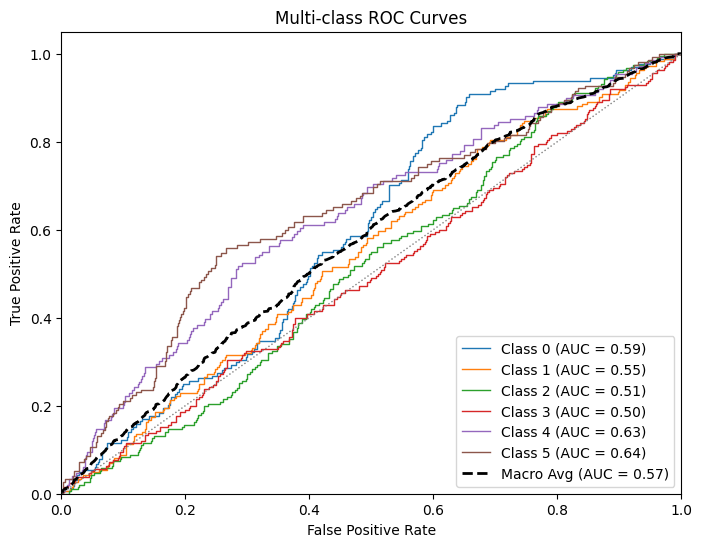

In [157]:
# 1) Binarize the true labels for all 6 classes
classes = [0, 1, 2, 3, 4, 5]
y_test_bin = label_binarize(y_test, classes=classes)

# 2) Get the predicted probabilities from your final pipeline
# (must be the pipeline with predict_proba)
y_score = final_pipeline.predict_proba(X_test)

# 3) Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4) Compute macro‐average ROC AUC
# flatten all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))
# interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in classes:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5) Plot
plt.figure(figsize=(8, 6))
# per‐class curves
for i, cls in enumerate(classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=1,
        label=f"Class {cls} (AUC = {roc_auc[i]:.2f})"
    )
# macro curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    color="black",
    lw=2,
    linestyle="--",
    label=f"Macro Avg (AUC = {roc_auc['macro']:.2f})"
)
# chance line
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle=":")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi‐class ROC Curves")
plt.legend(loc="lower right")
plt.show()


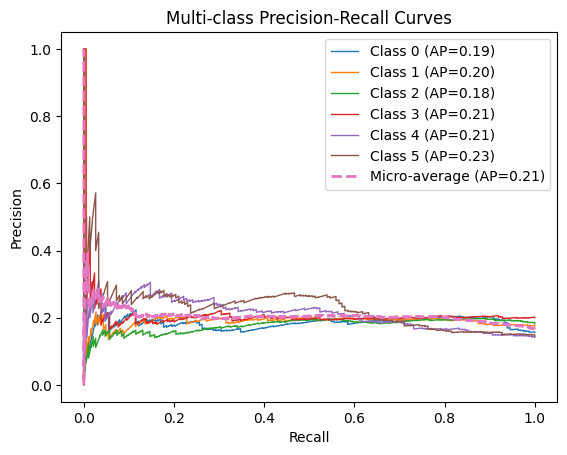

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.17      0.32      0.23       164
           1       0.17      0.20      0.19       184
           2       0.17      0.10      0.12       191
           3       0.24      0.11      0.16       210
           4       0.23      0.29      0.26       149
           5       0.23      0.21      0.22       152

    accuracy                           0.20      1050
   macro avg       0.20      0.21      0.19      1050
weighted avg       0.20      0.20      0.19      1050



In [158]:
precision = {}
recall = {}
average_precision = {}
for i in classes:
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Compute micro-average PR
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")

# Plot curves
plt.figure()
for i in classes:
    plt.plot(recall[i], precision[i], lw=1, label=f"Class {i} (AP={average_precision[i]:.2f})")
plt.plot(recall["micro"], precision["micro"], linestyle='--', lw=2,
         label=f"Micro-average (AP={average_precision['micro']:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curves")
plt.legend(loc="upper right")
plt.show()

# 7) Print classification report
y_pred = final_pipeline.predict(X_test)
print("Classification Report (Test):")
print(classification_report(y_test, y_pred))